In [22]:
import pandas as pd
import numpy as np
import re
import os
import nltk
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
import json

from os.path import join
from sklearn.model_selection import StratifiedShuffleSplit
from fasttext import load_model
from tqdm import tqdm

#visualization
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc

import random

## Разделение данных

In [10]:
def read_dataset(filepath, duplicates=False, clean=True):
    file = open(filepath, 'r', encoding='ISO-8859-1')
    data = pd.read_csv(file)

    old_names = data.keys()
    names = [n.encode('ISO-8859-1').decode('cp1251').encode('utf8') for n in old_names]
    names = [n.decode('utf-8') for n in names]

    new_data = dict()
    for old, new in zip(old_names, names):
        new_data[new] = list()
        for c in data[old]:
            try:
                s = c.encode('ISO-8859-1').decode('cp1251').encode('utf8')
                s = s.decode('utf-8')
                new_data[new].append(s)
            except AttributeError:
                new_data[new].append(c)

    new_data = pd.DataFrame(new_data, columns=['Описание', 'Категория жалобы'])
    new_data.rename(columns={'Описание': 'request', 'Категория жалобы': 'class'}, inplace=True)
    new_data = new_data.dropna()  # dell nan
    if not duplicates:
        new_data = new_data.drop_duplicates()  # dell duplicates

    # как отдельную ветвь можно использовать
    if clean:
        delete_bad_symbols = lambda x: " ".join(re.sub('[^а-яa-zё0-9]', ' ', x.lower()).split())
        new_data['request'] = new_data['request'].apply(delete_bad_symbols)

    new_data = new_data.reset_index()
    new_data = new_data.drop('index', axis=1)

    return new_data


path = '../data/vkusvill_all_categories.csv'
global_data = read_dataset(path)

/home/mks/intent/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (6,7,10,14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [46]:
dd = dict()
cd = dict()

for x, y in zip(global_data['request'], global_data['class']):
    if y not in dd.keys():
        dd[y] = list()
        cd[y] = 0
        dd[y].append((x, y))
        cd[y] += 1
    else:
        dd[y].append((x, y))
        cd[y] += 1

# print(dd[1])
print(cd)

{1: 3288, 2: 5312, 3: 6791, 4: 1366, 5: 80, 6: 9600, 7: 3634, 8: 442, 9: 906, 10: 3501, 11: 2039, 12: 2287, 13: 3568, 14: 205, 15: 1188, 16: 922, 17: 42}


In [47]:
prop = [0.1, 0.1]

if type(prop) is list:
    assert len(prop) == 2
    assert type(prop[0]) is float

    valid_ = dict()
    test_ = dict()

    for x in dd.keys():
        num = int(cd[x]*prop[0])
        valid_[x] = random.sample(dd[x], num)
        [dd[x].remove(t) for t in valid_[x]]

    for x in dd.keys():
        num = int(cd[x]*prop[1])
        test_[x] = random.sample(dd[x], num)
        [dd[x].remove(t) for t in test_[x]]
else:
    raise ValueError('Split proportion must be list of floats, with length = 2')

train_ = dd

In [48]:
train, valid, test = list(), list(), list()


for x in train_.keys():
    for z_, z in zip([train_, valid_, test_], [train, valid, test]):
        z.extend(z_[x])

del train_, valid_, test_, dd

for z in [train, valid, test]:
    z = random.shuffle(z)

In [50]:
utrain, uvalid, utest, ctrain, cvalid, ctest = list(), list(), list(), list(), list(), list()

In [51]:
for z, n, c in zip([train, valid, test], [utrain, uvalid, utest], [ctrain, cvalid, ctest]):
    for x in z:
        n.append(x[0])
        c.append(x[1])

In [53]:
train = pd.DataFrame({'request': utrain,
                     'class': ctrain})
valid = pd.DataFrame({'request': uvalid,
                     'class': cvalid})
test = pd.DataFrame({'request': utest,
                     'class': ctest})

In [54]:
test

,class,request
0,3,арбуз он явно не из астрахани я сама там жила ...
1,13,адреса магазинов вв в санкт петербурге спасибо
2,13,как зайти в лк
3,2,не перестаете нас удивлять последнее время пле...
4,7,торт наполеон с халвой это отдельная история в...
5,6,сегодня днем я с ребенком в вашем магазине по ...
6,3,13 09 2017 13 24 35 добрый день вчера купила м...
7,3,здравствуйте 16 мая я купила брынзу в магазине...
8,6,здравствуйте на днях была в магазине в сергиев...
9,11,добрый день убедительная просьба вернуть в маг...


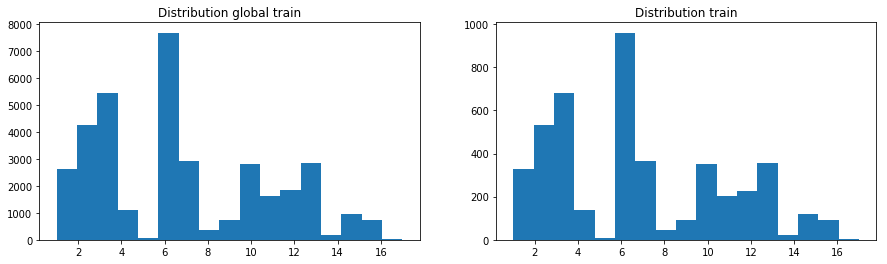

In [55]:
fig, ax = plt.subplots()
fig.set_figwidth(15)

plt.subplot(1, 2, 1)
plt.title('Distribution global train')
plt.hist(train['class'], bins=17)  # 70

plt.subplot(1, 2, 2)
plt.title('Distribution train')
plt.hist(test['class'], bins=17)  # 70
plt.show()

## Отработка препроцессинга в классе pipeline

In [8]:
import random
import pandas as pd
from typing import Generator
from sklearn.model_selection import train_test_split


class Dataset(object):
    def __init__(self, data, seed=None, split=True, splitting_proportions=None, *args, **kwargs):

        rs = random.getstate()
        random.seed(seed)
        self.random_state = random.getstate()
        random.setstate(rs)

        if splitting_proportions is None:
            self.splitting_proportions = [0.1, 0.1]
        else:
            self.splitting_proportions = splitting_proportions

        if not split:
            self.train = data.get('train', [])
            self.test = data.get('test', [])
            try:
                self.valid = data.get('valid', [])
                self.data = {'train': self.train,
                             'test': self.test,
                             'valid': self.valid,
                             'all': self.train + self.test}
            except KeyError:
                self.data = {'train': self.train,
                             'test': self.test,
                             'all': self.train + self.test}
        else:
            self.train, self.valid, self.test = self.split_data(data)
            self.data = {'train': self.train,
                         'test': self.test,
                         'valid': self.valid,
                         'all': self.train + self.test}

        self.data['classes'] = data['class'].unique()  # np.array

    def batch_generator(self, batch_size: int, data_type: str = 'train') -> Generator:
        r"""This function returns a generator, which serves for generation of raw (no preprocessing such as tokenization)
         batches
        Args:
            batch_size (int): number of samples in batch
            data_type (str): can be either 'train', 'test', or 'valid'
        Returns:
            batch_gen (Generator): a generator, that iterates through the part (defined by data_type) of the dataset
        """
        data = self.data[data_type]
        data_len = len(data)
        order = list(range(data_len))

        rs = random.getstate()
        random.setstate(self.random_state)
        random.shuffle(order)
        self.random_state = random.getstate()
        random.setstate(rs)

        # for i in range((data_len - 1) // batch_size + 1):
        #     yield list(zip(*[data[o] for o in order[i * batch_size:(i + 1) * batch_size]]))
        for i in range((data_len - 1) // batch_size + 1):
            o = order[i * batch_size:(i + 1) * batch_size]
            yield list((list(data['request'][o]), list(data['class'][o])))

    def iter_all(self, data_type: str = 'train') -> Generator:
        """
        Iterate through all data. It can be used for building dictionary or
        Args:
            data_type (str): can be either 'train', 'test', or 'valid'
        Returns:
            samples_gen: a generator, that iterates through the all samples in the selected data type of the dataset
        """
        data = self.data[data_type]
        for x, y in zip(data['request'], data['class']):
            yield (x, y)

    def _split_data(self, splitting_proportions, field_to_split, splitted_fields):
        data_to_div = self.data[field_to_split].copy()
        data_size = len(self.data[field_to_split])
        for i in range(len(splitted_fields) - 1):
            self.data[splitted_fields[i]], data_to_div = train_test_split(data_to_div,
                                                                          test_size=
                                                                          len(data_to_div) -
                                                                          int(data_size * splitting_proportions[i]))
        self.data[splitted_fields[-1]] = data_to_div
        return True

    def split_data(self, dataset):

        dd = dict()
        cd = dict()
        train = list()
        valid = list()
        test = list()

        for x, y in zip(dataset['request'], dataset['class']):
            if y not in dd.keys():
                dd[y] = list()
                cd[y] = 0
                dd[y].append((x, y))
                cd[y] += 1
            else:
                dd[y].append((x, y))
                cd[y] += 1

        if type(self.splitting_proportions) is list:
            assert len(self.splitting_proportions) == 2
            assert type(self.splitting_proportions[0]) is float

            valid_ = dict()
            test_ = dict()

            for x in dd.keys():
                num = int(cd[x] * self.splitting_proportions[0])
                valid_[x] = random.sample(dd[x], num)
                [dd[x].remove(t) for t in valid_[x]]

            for x in dd.keys():
                num = int(cd[x] * self.splitting_proportions[1])
                test_[x] = random.sample(dd[x], num)
                [dd[x].remove(t) for t in test_[x]]
        else:
            raise ValueError('Split proportion must be list of floats, with length = 2')

        train_ = dd

        for x in train_.keys():
            for z_, z in zip([train_, valid_, test_], [train, valid, test]):
                z.extend(z_[x])

        del train_, valid_, test_, dd, cd, dataset  # really need ?

        for z in [train, valid, test]:
            z = random.shuffle(z)

        utrain, uvalid, utest, ctrain, cvalid, ctest = list(), list(), list(), list(), list(), list()
        for z, n, c in zip([train, valid, test], [utrain, uvalid, utest], [ctrain, cvalid, ctest]):
            for x in z:
                n.append(x[0])
                c.append(x[1])

        train = pd.DataFrame({'request': utrain,
                              'class': ctrain})
        valid = pd.DataFrame({'request': uvalid,
                              'class': cvalid})
        test = pd.DataFrame({'request': utest,
                             'class': ctest})

        return train, valid, test

    def _merge_data(self, fields_to_merge):
        data = self.data.copy()
        new_name = [s + '_' for s in fields_to_merge]
        data[new_name] = []
        for name in fields_to_merge:
            data[new_name] += self.data[name]
        self.data = data
        return True

In [11]:
path = '../data/vkusvill_all_categories.csv'
global_data = read_dataset(path)

dataset = Dataset(global_data, seed=42)

/home/mks/intent/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (6,7,10,14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### Cleaning

In [13]:
config = {'nan': True, 'repeat': True}
def clean(data):
    if config['nan']:
        data = data.dropna()
    if config['repeat']:
        data = data.drop_duplicates()
    return data

for x in ['train', 'valid', 'test']:
    dataset.data[x] = clean(dataset.data[x])

In [17]:
print(dataset.data['classes'])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [53]:
config = {'tokenization': False, 'lemma': True, 'n-gram': False}

def tokenizer(data):
    if not config['tokenization']:
        data, ans = tokenization(data, morph=config['lemma'], ngram=config['n-gram'])
        new_data = list()
        for x in data:
            new_data.append(' '.join(x))
            data = new_data
    else:
        data = tokenization(data, morph=config['lemma'], ngram=config['n-gram'])
    return data

def tokenize(sen):
    sent_toks = nltk.sent_tokenize(sen)
    word_toks = [nltk.word_tokenize(el) for el in sent_toks]
    tokens = [val for sublist in word_toks for val in sublist]
    tokens = [el for el in tokens if el != '']
    tokens = [el.lower() for el in tokens]
    tokens = [morph.parse(el)[0].normal_form for el in tokens]
    return tokens


def tokenization(data, morph=True, ngram=True):
    dataset = list()
    ans = list()

    for x, y in tqdm(zip(data['request'], data['class'])):
        if morph:
            tokens = tokenize(x)
        else:
            sent = nltk.sent_tokenize(x)
            word_toks = [nltk.word_tokenize(el) for el in sent]
            tokens = [val for sublist in word_toks for val in sublist]

        if ngram:
            bigrm = nltk.bigrams(tokens)
            tokens = tokens.extend(bigrm)

        dataset.append(tokens)
        ans.append(y)

    return dataset, ans

In [84]:
def tok(st, low, lem):
    sent_toks = nltk.sent_tokenize(st)
    word_toks = [nltk.word_tokenize(el) for el in sent_toks]
    tokens = [val for sublist in word_toks for val in sublist]
    tokens = [el for el in tokens if el != '']
    if low:
        tokens = [el.lower() for el in tokens]
    if lem:
        tokens = [morph.parse(el)[0].normal_form for el in tokens]
    return tokens


def tokenize_(data, lower=True, lemma=True, dtype='tokens'):
    Tokens = list()
    for x in data['request']:
        tokens = tok(x, lower, lemma)
        if dtype == 'tokens':
            Tokens.append(tokens)
        elif dtype == 'str':
            Tokens.append(' '.join(tokens))
        else:
            raise ValueError
    
    if dtype == 'tokens':
        return (Tokens, data['class'])
    elif dtype == 'str':
        data['request'] = Tokens
        return data

In [96]:
dataset.data['tok1'] = tokenize_(dataset.data['test'], lemma=False, lower=True, dtype='str')

In [97]:
dataset.data['tok1']

,class,request
0,11,вкусвилл я сегодня попробовать творог из топлё...
1,3,клюква в сахарный пудра ранний и сам брать с у...
2,2,добрый день я ильин екатерина 16 06 я покупать...
3,12,зарегистрировать карта через смс сообщение пар...
4,11,вкусвилл очень бы хотеться чтобы на прилавок в...
5,6,добрый день хотеть бы сказать спасибо продавец...
6,4,торт киевский от 23 09 не похожий на киевский ...
7,12,в скидка из телеграм я в магазин указать топлё...
8,8,на вкус сухарик с укроп будто с добавка чеснок...
9,11,здравствовать в магазин по адрес год жуковский...
